In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df=pd.read_csv('final_data.csv')

<Axes: ylabel='estimation_ges'>

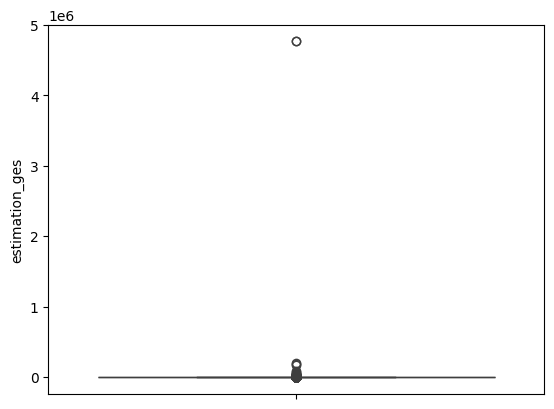

In [11]:
sns.boxplot(df['estimation_ges'])

In [12]:
unique_sect_act=df['secteur_activite'].unique()

In [13]:
unique_sect_act

array(['Autres cas (par exemple: théâtres, salles de sport, restauration, commerces individuels, etc)',
       "Bâtiment à usage principale de bureau, d'administration ou d'enseignement",
       'Centre commercial',
       'Bâtiment à occupation continue (par exemple: hopitaux, hôtels, internats, maisons de retraite, etc)'],
      dtype=object)

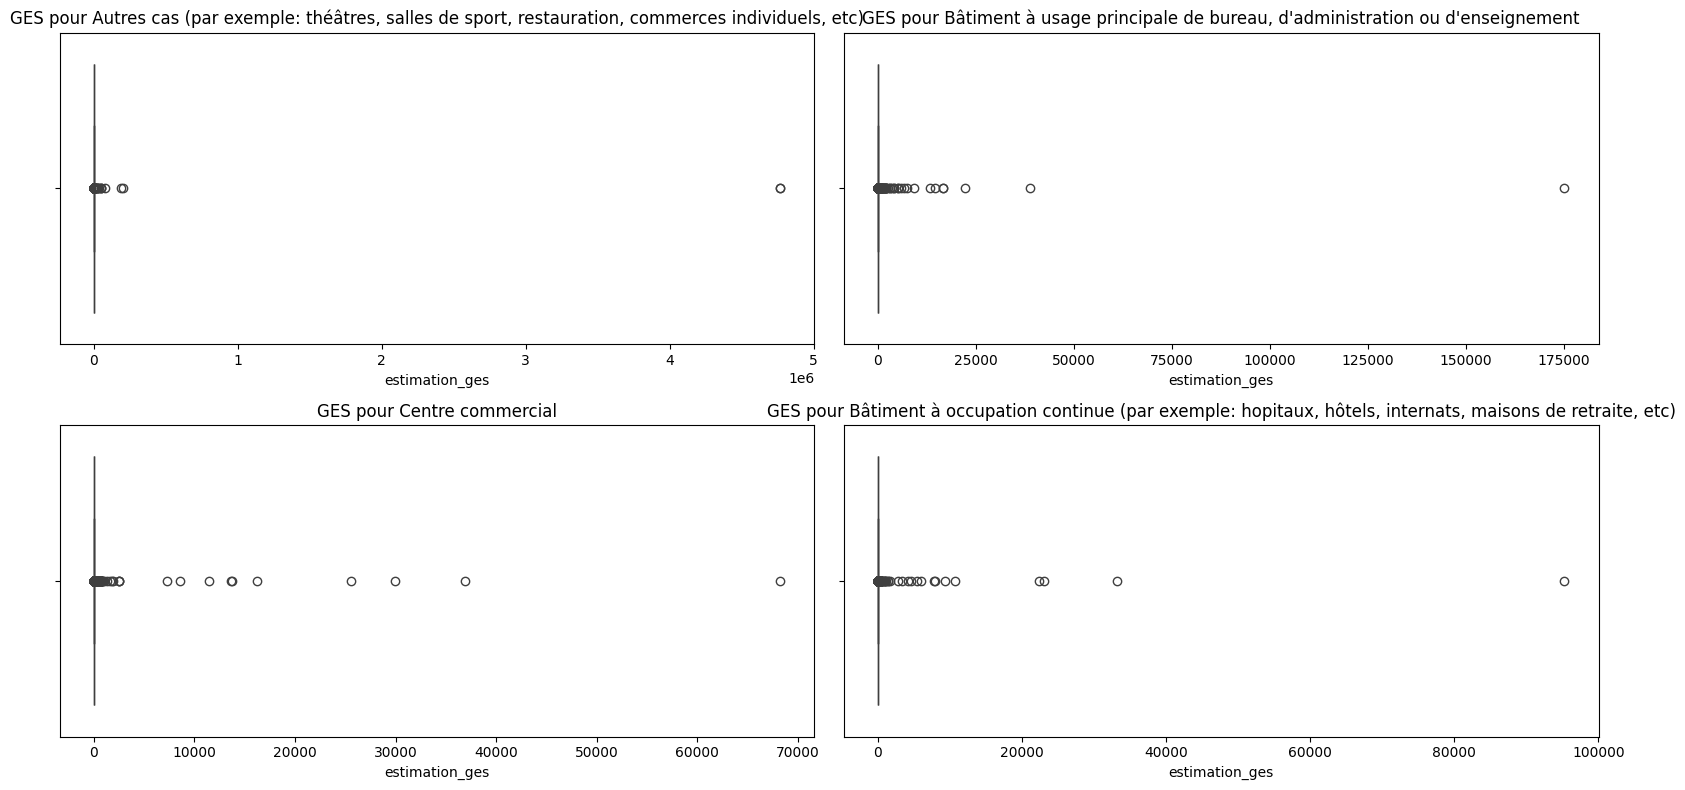

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))  
axs = axs.flatten()  # Transformer en liste 1D pour un accès plus facile

# Boucle sur les secteurs d'activité
for i, sec_act in enumerate(unique_sect_act):
    filter = df['secteur_activite'] == sec_act
    sns.boxplot(x=df.loc[filter, 'estimation_ges'], ax=axs[i])
    axs[i].set_title(f"GES pour {sec_act}")

# Ajuster l'affichage
plt.tight_layout()
plt.show()

In [15]:
def remove_outliers(group):
    Q1 = group['estimation_ges'].quantile(0.25)
    Q3 = group['estimation_ges'].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['estimation_ges'] >= lower_bound) & (group['estimation_ges'] <= upper_bound)]

# Appliquer la suppression des outliers sur chaque (store_id, product_id)
df_cleaned = df.groupby(['secteur_activite'], group_keys=False).apply(remove_outliers)
print(f'the percentage of the outliers is {100*(1-len(df_cleaned)/len(df)):.2}%')

the percentage of the outliers is 2.1%


C:\Users\mnica\AppData\Local\Temp\ipykernel_19880\2760209758.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df.groupby(['secteur_activite'], group_keys=False).apply(remove_outliers)


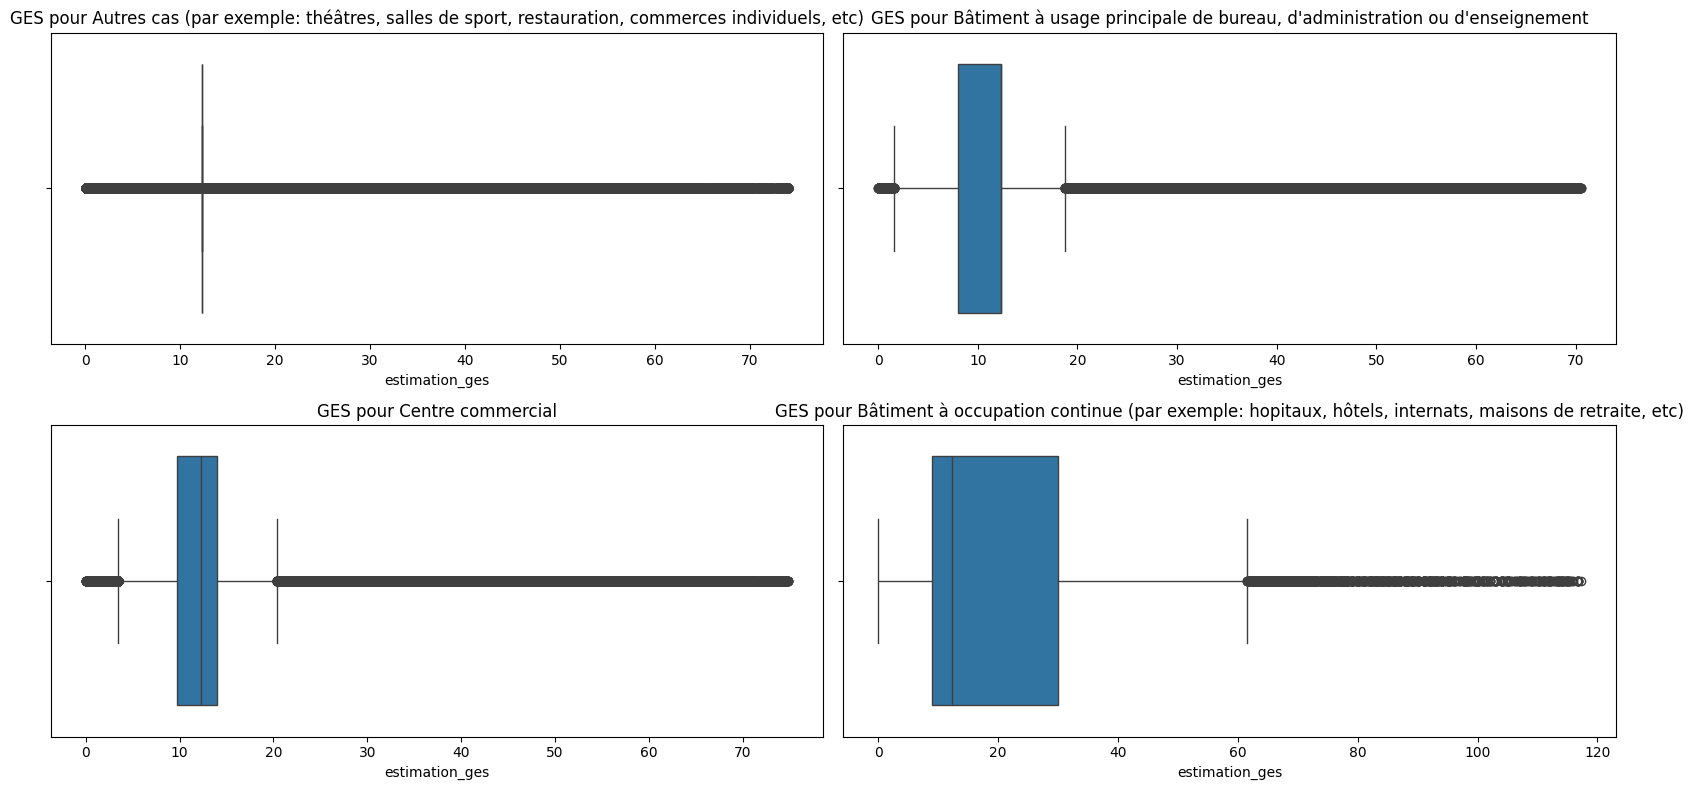

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))  
axs = axs.flatten()  # Transformer en liste 1D pour un accès plus facile

# Boucle sur les secteurs d'activité
for i, sec_act in enumerate(unique_sect_act):
    filter = df_cleaned['secteur_activite'] == sec_act
    sns.boxplot(x=df_cleaned.loc[filter, 'estimation_ges'], ax=axs[i])
    axs[i].set_title(f"GES pour {sec_act}")

# Ajuster l'affichage
plt.tight_layout()
plt.show()

In [17]:
df=df_cleaned

In [18]:
#%%  Séparer les bâtiments selon le secteur d'activité


# Dictionnaire des valeurs possibles et des noms de fichiers associés
dict = {
    "Autres cas (par exemple: théâtres, salles de sport, restauration, commerces individuels, etc)": "autre.csv",
    "Bâtiment à occupation continue (par exemple: hopitaux, hôtels, internats, maisons de retraite, etc)": "occupation_continue.csv",
    "Centre commercial": "centre_commercial.csv",
    "Bâtiment à usage principale de bureau, d'administration ou d'enseignement": "bureau_admin_enseignement.csv"
}

# Boucle pour filtrer et enregistrer chaque catégorie
for valeur, fichier in dict.items():
    df_filtre = df[df["secteur_activite"] == valeur]
    df_filtre = df_filtre.groupby('date_etablissement_dpe').apply(
    lambda g: (g['estimation_ges'] * g['shon']).sum() / g['shon'].sum()
,include_groups=False).reset_index(name='estimation_ges')
    df_filtre.to_csv(fichier, index=False)
    print(f"{len(df_filtre)} lignes enregistrées dans {fichier}")

4215 lignes enregistrées dans autre.csv
3735 lignes enregistrées dans occupation_continue.csv
4188 lignes enregistrées dans centre_commercial.csv
4282 lignes enregistrées dans bureau_admin_enseignement.csv


In [19]:
dict_fichiers = {
    "Autres cas (par exemple: théâtres, salles de sport, restauration, commerces individuels, etc)": "autre.csv",
    "Bâtiment à occupation continue (par exemple: hopitaux, hôtels, internats, maisons de retraite, etc)": "occupation_continue.csv",
    "Centre commercial": "centre_commercial.csv",
    "Bâtiment à usage principale de bureau, d'administration ou d'enseignement": "bureau_admin_enseignement.csv"
}

df["date_etablissement_dpe"] = pd.to_datetime(df["date_etablissement_dpe"], errors="coerce")

# Boucle pour filtrer et enregistrer chaque catégorie
for valeur, fichier in dict_fichiers.items():
    df_filtre = df[df["secteur_activite"] == valeur].copy()
    
    # Créer une colonne "mois" au format YYYY-MM
    df_filtre["mois"] = df_filtre["date_etablissement_dpe"].dt.to_period("M")
    
    # Calculer la moyenne pondérée des émissions de GES pour chaque mois
    df_mois = df_filtre.groupby("mois").apply(
        lambda g: (g["estimation_ges"] * g["shon"]).sum() / g["shon"].sum(),
        include_groups=False
    ).reset_index(name="estimation_ges")
    # Sauvegarder avec "_mois" ajouté au nom du fichier
    fichier_mois = fichier.replace(".csv", "_mois.csv")
    df_mois.to_csv(fichier_mois,index=False)